<p>
    <img src="https://s3.amazonaws.com/iotanalytics-templates/Logo.png" style="float:left;width:65px">
    <h1 style="float:left;color:#1A5276;padding-left:15px;font-size:20px;">AWS IoT Analytics | Notebook</h1>
</p>


When loading data from IoT Analytics datasets, the client should be initialized first.

We ae also creating another client `iot-data` to enable the features that will help us to publish the data on a specific topic. 

To utilize these featres we are using boto3 library. 

In [2]:
import boto3

# create IoT Analytics client
client = boto3.client('iotanalytics')

anomaly_client = boto3.client('iot-data', region_name='us-east-1', endpoint_url = 'https://a1vhfu9yqro3wg-ats.iot.us-east-1.amazonaws.com')

In the following cell we are importing libraries which will beused through put the program. To save the data we are importing pandas which a dataframe, along panadas we are using matplotlib to plot the graph and json to jsnoify the relevant data ojects. 

In [1]:
from __future__ import unicode_literals, division
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import json
import requests
import urllib3

%matplotlib inline
matplotlib.rcParams['figure.figsize'] = (17, 10)

In the following cell we are accessing the dataset named as `bsm_dataset` to get the information which was pushed by BedSideMonitor.py. 

This the same datset which we created in the companion `SetUp` Notebook. 

Once the consolidated data wich has the values for heartrate, spo2 and temperature is available, we will create indvidual dataframe objects for each datatype seperately.  

`heartrate_df`, `oxygenlevel_df` and `temperature_df` are the newly created dataframes from the `df` dataframe.  

In [112]:
dataset = "bsm_dataset"
dataset_url = client.get_dataset_content(datasetName = dataset,versionId='$LATEST')['entries'][0]['dataURI']

# start working with the data

time_col = 'timestamp'
value_col = 'value' 
df = pd.read_csv(dataset_url, index_col=time_col, parse_dates=True, dtype={value_col: float}).sort_index()

#print(df.head(35))


heartrate_df= df[df.datatype == 'HeartRate']

oxygenlevel_df= df[df.datatype == 'SPO2']

temperature_df= df[df.datatype == 'Temperature']

print(heartrate_df.index)

if df.empty:
    raise Exception('No data found')
if (value_col not in heartrate_df):
    value_col = heartrate_df.columns[0]

DatetimeIndex(['2021-05-11 20:51:02.867894', '2021-05-11 20:51:04.516642',
               '2021-05-11 20:51:05.158018', '2021-05-11 20:51:05.860967',
               '2021-05-11 20:51:06.865696', '2021-05-11 20:51:07.865411',
               '2021-05-11 20:51:08.859913', '2021-05-11 20:51:09.861780',
               '2021-05-11 20:51:10.857016', '2021-05-11 20:51:11.861418',
               ...
               '2021-05-11 20:59:52.869331', '2021-05-11 20:59:54.177864',
               '2021-05-11 20:59:54.858415', '2021-05-11 20:59:55.861464',
               '2021-05-11 20:59:56.869282', '2021-05-11 20:59:57.863608',
               '2021-05-11 20:59:58.855995', '2021-05-11 20:59:59.859207',
               '2021-05-11 21:00:00.870189', '2021-05-11 21:00:01.857184'],
              dtype='datetime64[ns]', name='timestamp', length=540, freq=None)


For anmolay detection for the data received we are going to use enhanced version of EWMA (Expoential Weighted Moving Average) algorithm. 

An exponentially weighted moving average is a way to continuously compute a type of average for a series of numbers, as the numbers arrive. 

After a value in the series is added to the average, its weight in the average decreases exponentially over time. This biases the average towards more recent data. EWMAs are useful for several reasons, chiefly their inexpensive computational and memory cost, as well as the fact that they represent the recent central tendency of the series of values.

The EWMA algorithm requires a decay factor, alpha. The larger the alpha, the more the average is biased towards recent history. The alpha must be between 0 and 1.

For IoT data, where physical processes tend to produce particularly noisy data, EWMA is, unfortunately, sensitive to abrupt changes in data trends. For this reason, we'll use a probabilistic approach to EWMA, or PEWMA. This is a modification of the exponentially weighted moving average in which outlier data points are dampened so that they influence the moving average less.


## Set PEWMA Algorithm Parameters

PEWMA requires the input of initialization and fitting parameters. There are 3 key parameters used to configure the PEWMA model. They include the initial sample size to calculate the starting moving average

T is the number of data points used to calculate the initial value for the moving average. The default value is 20. Beta is the dampening factor that prevents anomalies from strongly shifting the mean. The larger the value, the more we limit the effect an anomalous data point has on the mean. Beta ranges from 0 to 1. 

With our sample Data Set we use a default of 0.5. a or alpha is used to specify how much weight to give to the previous value of the mean in determining the moving average. The closer this parameter is to 1, the smoother the moving average will be. The closer this parameter is to 0, the more quickly the moving average will adjust to changing patterns in the data. The default value is 0.9.

In [95]:
T = 20   # initialization period (in cycles)
beta = 0.05  # lower values make the algorithm behave more like regular EWMA
a = 0.9	# the maximum value of the EWMA a parameter, used for outliers

## Set Anomaly Threshold

The PEWMA anomaly threshold parameter sets the limit for what we call an anomaly. The lower the value, the more points will be classified as anomalies. Raising the threshold increases the area that is considered normal.

Specify z - the number of running standard deviations that should be considered an anomaly

In [96]:
z = 2

In [97]:
from itertools import islice
from math import sqrt
from scipy.stats import norm

# create a DataFrame for the run time variables we'll need to calculate
pewm = pd.DataFrame(index=heartrate_df.index, columns=['Mean', 'Var', 'Std'], dtype=float)
pewm.iloc[0] = [heartrate_df.iloc[0][value_col], 0, 0]
t = 0
for _, row in islice(heartrate_df.iterrows(), 1, None):
    diff = row[value_col] - pewm.iloc[t].Mean # difference from moving average
    p = norm.pdf(diff / pewm.iloc[t].Std) if pewm.iloc[t].Std != 0 else 0 # Prob of observing diff
    a_t = a * (1 - beta * p) if t > T else 1 - 1/(t+1) # weight to give to this point
    incr = (1 - a_t) * diff
   
    # Update Mean, Var, Std
    pewm.iloc[t+1].Mean = pewm.iloc[t].Mean + incr
    pewm.iloc[t+1].Var = a_t * (pewm.iloc[t].Var + diff * incr)
    pewm.iloc[t+1].Std = sqrt(pewm.iloc[t+1].Var)
    t += 1
    
print(diff, incr, p, a_t)

6.295177056743739 0.729605397488096 0.3533134825510853 0.8841008932852011


After making the initial calculation, next we are going to find out the outliers/anomaly in our heartrate_dataframe. 

As we know, all the data points will be saved in a dataframe format. After performing the anomaly detection each data points should be then forwarded as a json object. To do this first we will convert the dataframe into json_list, once dne each of the element inside list will be treated as json_object and then will be published on the topic `iot/bsm/anomaly`. 

We have subscribed to the same topic in node-red to publish and view the data on node-red-dashboard.

[{'deviceid': 'BSM_G102', 'datatype': 'HeartRate', 'value': 113.0, '__dt': '2021-05-11 00:00:00.000'}, {'deviceid': 'BSM_G102', 'datatype': 'HeartRate', 'value': 63.0, '__dt': '2021-05-11 00:00:00.000'}, {'deviceid': 'BSM_G102', 'datatype': 'HeartRate', 'value': 111.0, '__dt': '2021-05-11 00:00:00.000'}, {'deviceid': 'BSM_G102', 'datatype': 'HeartRate', 'value': 57.0, '__dt': '2021-05-11 00:00:00.000'}, {'deviceid': 'BSM_G102', 'datatype': 'HeartRate', 'value': 57.0, '__dt': '2021-05-11 00:00:00.000'}, {'deviceid': 'BSM_G102', 'datatype': 'HeartRate', 'value': 61.0, '__dt': '2021-05-11 00:00:00.000'}, {'deviceid': 'BSM_G102', 'datatype': 'HeartRate', 'value': 118.0, '__dt': '2021-05-11 00:00:00.000'}, {'deviceid': 'BSM_G102', 'datatype': 'HeartRate', 'value': 61.0, '__dt': '2021-05-11 00:00:00.000'}, {'deviceid': 'BSM_G102', 'datatype': 'HeartRate', 'value': 53.0, '__dt': '2021-05-11 00:00:00.000'}, {'deviceid': 'BSM_G102', 'datatype': 'HeartRate', 'value': 113.0, '__dt': '2021-05-11 0

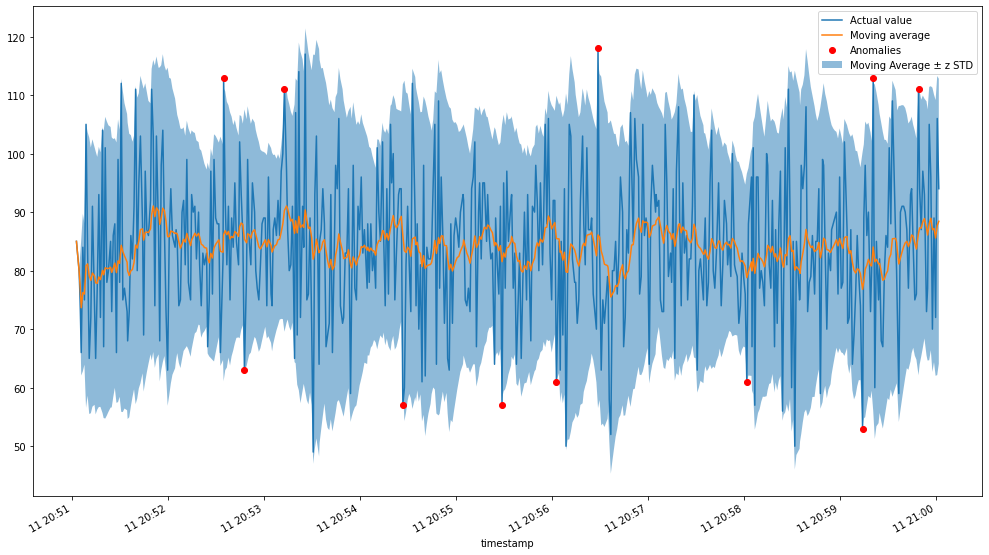

In [100]:
_, ax = plt.subplots() # initialize plot

# Define the boundary for what is considered an anomaly
pewm['Mean_plus_zStd'] = pewm.Mean.add(pewm.Std.mul(z))
pewm['Mean_minus_zStd'] = pewm.Mean.sub(pewm.Std.mul(z))

# Identify anomalies
anomalies = heartrate_df[(heartrate_df[value_col] > pewm['Mean_plus_zStd']) | (heartrate_df[value_col] < pewm['Mean_minus_zStd'])]

#print((anomalies))

json_list = json.loads(json.dumps(list(anomalies.T.to_dict().values())))

print(json_list)


for anomaly in json_list:
    Payload=json.dumps(anomaly)
    anomaly_client.publish(topic= 'iot/bsm/anomaly',qos=0,payload=Payload)
    urllib3.disable_warnings(urllib3.exceptions.InsecureRequestWarning)    
    
heartrate_df.plot(y = value_col, ax = ax) # plot raw data
pewm.plot(y = 'Mean', ax = ax) # plot moving average
if not anomalies.empty:
    anomalies.plot(y = value_col, ax = ax, style=['ro']) # plot anomalies as red dots
ax.fill_between(heartrate_df.index, pewm.Mean_plus_zStd, pewm.Mean_minus_zStd, alpha=0.5) # fill the regions showing boundary for anomalies
ax.legend(['Actual value', 'Moving average', 'Moving Average + z STD', 'Moving Average - z STD']);
if not anomalies.empty:
    ax.legend(['Actual value', 'Moving average', 'Anomalies', 'Moving Average ± z STD']);
else:
    ax.legend(['Actual value', 'Moving average', 'Moving Average ± z STD']);

Similar to what we did in previous section we are going to find out anomalies for the oxygenlevel_df. 

In [101]:
T = 20 		# initialization period (in cycles)
beta = 0.5	# lower values make the algorithm behave more like regular EWMA
a = 0.2     	# the maximum value of the EWMA a parameter, used for outliers

In [102]:
z = 1

In [103]:
from itertools import islice
from math import sqrt
from scipy.stats import norm

# create a DataFrame for the run time variables we'll need to calculate
pewm = pd.DataFrame(index=oxygenlevel_df.index, columns=['Mean', 'Var', 'Std'], dtype=float)
pewm.iloc[0] = [oxygenlevel_df.iloc[0][value_col], 0, 0]
t = 0
for _, row in islice(oxygenlevel_df.iterrows(), 1, None):
    diff = row[value_col] - pewm.iloc[t].Mean # difference from moving average
    p = norm.pdf(diff / pewm.iloc[t].Std) if pewm.iloc[t].Std != 0 else 0 # Prob of observing diff
    a_t = a * (1 - beta * p) if t > T else 1 - 1/(t+1) # weight to give to this point
    incr = (1 - a_t) * diff
   
    # Update Mean, Var, Std
    pewm.iloc[t+1].Mean = pewm.iloc[t].Mean + incr
    pewm.iloc[t+1].Var = a_t * (pewm.iloc[t].Var + diff * incr)
    pewm.iloc[t+1].Std = sqrt(pewm.iloc[t+1].Var)
    t += 1

[{'deviceid': 'BSM_G102', 'datatype': 'SPO2', 'value': 86.0, '__dt': '2021-05-11 00:00:00.000'}, {'deviceid': 'BSM_G102', 'datatype': 'SPO2', 'value': 92.0, '__dt': '2021-05-11 00:00:00.000'}, {'deviceid': 'BSM_G102', 'datatype': 'SPO2', 'value': 87.0, '__dt': '2021-05-11 00:00:00.000'}, {'deviceid': 'BSM_G102', 'datatype': 'SPO2', 'value': 82.0, '__dt': '2021-05-11 00:00:00.000'}, {'deviceid': 'BSM_G102', 'datatype': 'SPO2', 'value': 92.0, '__dt': '2021-05-11 00:00:00.000'}, {'deviceid': 'BSM_G102', 'datatype': 'SPO2', 'value': 96.0, '__dt': '2021-05-11 00:00:00.000'}]


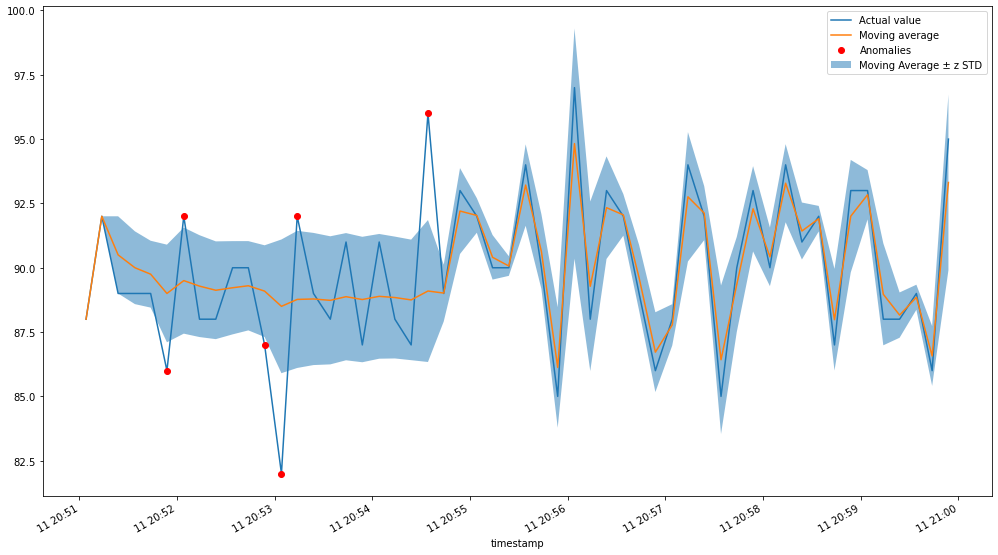

In [104]:
_, ax = plt.subplots() # initialize plot

# Define the boundary for what is considered an anomaly
pewm['Mean_plus_zStd'] = pewm.Mean.add(pewm.Std.mul(z))
pewm['Mean_minus_zStd'] = pewm.Mean.sub(pewm.Std.mul(z))

# Identify anomalies
anomalies = oxygenlevel_df[(oxygenlevel_df[value_col] > pewm['Mean_plus_zStd']) | (oxygenlevel_df[value_col] < pewm['Mean_minus_zStd'])]

json_list = json.loads(json.dumps(list(anomalies.T.to_dict().values())))

print(json_list)


for anomaly in json_list:
    Payload=json.dumps(anomaly)
    anomaly_client.publish(topic= 'iot/bsm/anomaly',qos=0,payload=Payload)
    urllib3.disable_warnings(urllib3.exceptions.InsecureRequestWarning) 

oxygenlevel_df.plot(y = value_col, ax = ax) # plot raw data
pewm.plot(y = 'Mean', ax = ax) # plot moving average
if not anomalies.empty:
    anomalies.plot(y = value_col, ax = ax, style=['ro']) # plot anomalies as red dots
ax.fill_between(oxygenlevel_df.index, pewm.Mean_plus_zStd, pewm.Mean_minus_zStd, alpha=0.5) # fill the regions showing boundary for anomalies
ax.legend(['Actual value', 'Moving average', 'Moving Average + z STD', 'Moving Average - z STD']);
if not anomalies.empty:
    ax.legend(['Actual value', 'Moving average', 'Anomalies', 'Moving Average ± z STD']);
else:
    ax.legend(['Actual value', 'Moving average', 'Moving Average ± z STD']);

Similar to what we did in previous section we are going to find out anomalies for the oxygenlevel_df. 

In [106]:
T = 20 		# initialization period (in cycles)
beta = 0.3	# lower values make the algorithm behave more like regular EWMA
a = 0.99     	# the maximum value of the EWMA a parameter, used for outliers

In [107]:
z = 2

In [108]:
from itertools import islice
from math import sqrt
from scipy.stats import norm

# create a DataFrame for the run time variables we'll need to calculate
pewm = pd.DataFrame(index=temperature_df.index, columns=['Mean', 'Var', 'Std'], dtype=float)
pewm.iloc[0] = [temperature_df.iloc[0][value_col], 0, 0]
t = 0
for _, row in islice(temperature_df.iterrows(), 1, None):
    diff = row[value_col] - pewm.iloc[t].Mean # difference from moving average
    p = norm.pdf(diff / pewm.iloc[t].Std) if pewm.iloc[t].Std != 0 else 0 # Prob of observing diff
    a_t = a * (1 - beta * p) if t > T else 1 - 1/(t+1) # weight to give to this point
    incr = (1 - a_t) * diff
   
    # Update Mean, Var, Std
    pewm.iloc[t+1].Mean = pewm.iloc[t].Mean + incr
    pewm.iloc[t+1].Var = a_t * (pewm.iloc[t].Var + diff * incr)
    pewm.iloc[t+1].Std = sqrt(pewm.iloc[t+1].Var)
    t += 1

[{'deviceid': 'BSM_G102', 'datatype': 'Temperature', 'value': 96.1, '__dt': '2021-05-11 00:00:00.000'}, {'deviceid': 'BSM_G102', 'datatype': 'Temperature', 'value': 101.5, '__dt': '2021-05-11 00:00:00.000'}, {'deviceid': 'BSM_G102', 'datatype': 'Temperature', 'value': 102.3, '__dt': '2021-05-11 00:00:00.000'}]


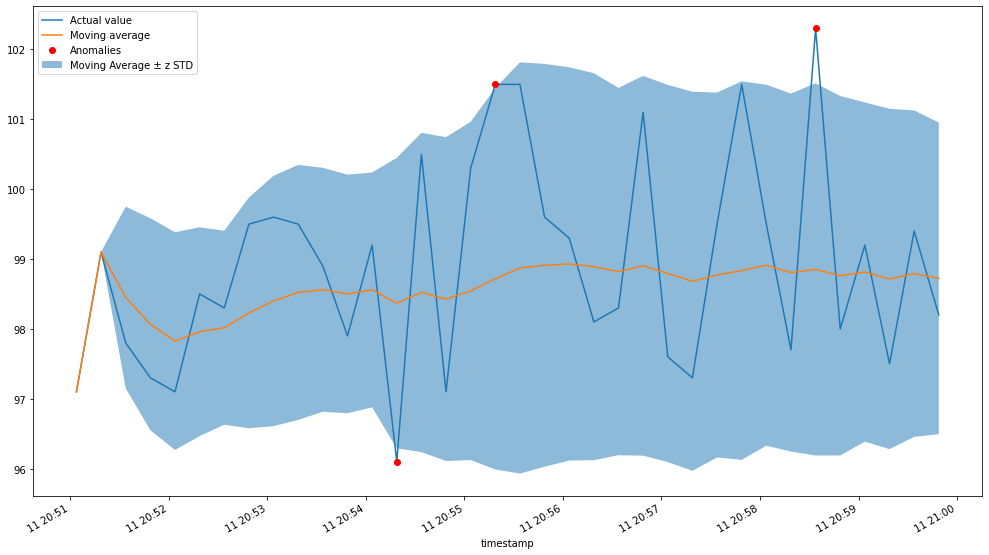

In [109]:
_, ax = plt.subplots() # initialize plot

# Define the boundary for what is considered an anomaly
pewm['Mean_plus_zStd'] = pewm.Mean.add(pewm.Std.mul(z))
pewm['Mean_minus_zStd'] = pewm.Mean.sub(pewm.Std.mul(z))

# Identify anomalies
anomalies = temperature_df[(temperature_df[value_col] > pewm['Mean_plus_zStd']) | (temperature_df[value_col] < pewm['Mean_minus_zStd'])]

json_list = json.loads(json.dumps(list(anomalies.T.to_dict().values())))

print(json_list)


for anomaly in json_list:
    Payload=json.dumps(anomaly)
    anomaly_client.publish(topic= 'iot/bsm/anomaly',qos=0,payload=Payload)
    urllib3.disable_warnings(urllib3.exceptions.InsecureRequestWarning) 

temperature_df.plot(y = value_col, ax = ax) # plot raw data
pewm.plot(y = 'Mean', ax = ax) # plot moving average
if not anomalies.empty:
    anomalies.plot(y = value_col, ax = ax, style=['ro']) # plot anomalies as red dots
ax.fill_between(temperature_df.index, pewm.Mean_plus_zStd, pewm.Mean_minus_zStd, alpha=0.5) # fill the regions showing boundary for anomalies
ax.legend(['Actual value', 'Moving average', 'Moving Average + z STD', 'Moving Average - z STD']);
if not anomalies.empty:
    ax.legend(['Actual value', 'Moving average', 'Anomalies', 'Moving Average ± z STD']);
else:
    ax.legend(['Actual value', 'Moving average', 'Moving Average ± z STD']);

<div style="height:60px;"><div style="height:7px;background-color:#20B3CD;width:100%;margin-top:20px;position:relative;"><img src="https://s3.amazonaws.com/iotanalytics-templates/Logo.png" style="height:50px;width:50px;margin-top:-20px;position:absolute;margin-left:42%;"></div></div>